# Reading Brick-files: DESI OSU Workshop Dec 6th-9th 2016

Authors: Javier Sanchez (francs1@uci.edu), David Kirkby (dkirkby@uci.edu)

First I set up the packages that I am going to need for the analysis

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as fits

In [3]:
import os

Brick files have a standard name `brick-{CHANNEL}-{BRICK_NAME}.fits`.

We are going to set up a function to read these files and give us the HDU lists.

### The brick files are located at NERSC in `/project/projectdirs/desi/datachallenge/OSU2016`

In [4]:
def readBricks(path_in,brick_name):
    hdus = []
    for channel in 'brz':
        filename = 'brick-{}-{}.fits'.format(channel,brick_name)
        hdulist = fits.open(os.path.join(path_in,filename))
        hdus.append(hdulist)
    return hdus

### Change `os.environ['FAKE_QSO_PATH']` to the path to the brick files in your computer

In [6]:
hdus = readBricks(os.environ['FAKE_QSO_PATH'],'qso-osu')

`hdus` is a list containing 3 `HDUList` objects. The `0` list corresponds to the `b` camera, the `1` to the `r`, and the `2` to the `z`. More info here: http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/PRODNAME/bricks/BRICKNAME/brick-CHANNEL-BRICKNAME.html

* The first hdu contains the fluxes
* The second hdu contains the inverse variance
* The third hdu contains the wavelength grid
* The fourth hdu contains the resolution matrix
* The fifth hdu contains the fibermap in a Table

In [7]:
def plot_smooth(nqso, nresample_b, nresample_r, nresample_z):
    x_b = np.mean(hdus[0][2].data.reshape(-1, nresample_b), axis=1)
    y_b = np.average(hdus[0][0].data[nqso,:].reshape(-1, nresample_b), axis=1, weights=hdus[0][1].data[nqso,:].reshape(-1, nresample_b))
    x_r = np.mean(hdus[1][2].data.reshape(-1, nresample_r), axis=1)
    y_r = np.average(hdus[1][0].data[nqso,:].reshape(-1, nresample_r), axis=1, weights=hdus[1][1].data[nqso,:].reshape(-1, nresample_r))
    x_z = np.mean(hdus[2][2].data[:-3].reshape(-1, nresample_z), axis=1)
    y_z = np.average(hdus[2][0].data[nqso,:-3].reshape(-1, nresample_z), axis=1, weights=hdus[2][1].data[nqso,:-3].reshape(-1, nresample_z))
    plt.plot(x_b,y_b,'b-',label='b')
    plt.plot(x_r,y_r,'y-',label='r')
    plt.plot(x_z,y_z,'r-',label='z')
    plt.xlabel(r'$\lambda (\AA)$')
    plt.ylabel(r'Flux $\times 10^{-17}$ [erg cm$^{-2}$s$^{-1}\AA^{-1}$]')
    plt.xlim(3300,9500)

The function `plot_smooth` plots an smoothed (downsampled and weighted by its inverse variance) version of the spectra. In this case I choose a different subsampling for each camera since they contain different number of pixels. The subsampling factor should be an integer divisor of the number of pixels in each camera. I select 20 for `b`, 23 for `r`, and 35 for `z`.

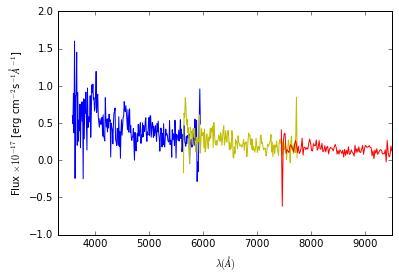

In [8]:
plot_smooth(0,20,23,35)

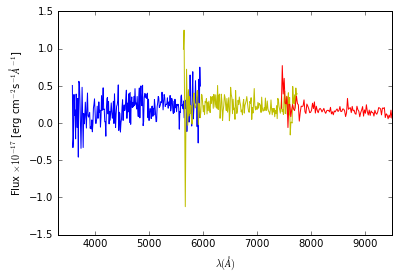

In [9]:
plot_smooth(2,20,23,35)

In [10]:
def plot_snr(nqso):
    x_b = hdus[0][2].data
    y_b = hdus[0][0].data[nqso,:]
    iv_b = hdus[0][1].data[nqso,:]
    res_b = (np.max(hdus[0][2].data)-np.min(hdus[0][2].data))/len(hdus[0][2].data)
    x_r = hdus[1][2].data
    y_r = hdus[1][0].data[nqso,:]
    iv_r = hdus[1][1].data[nqso,:]
    res_r = (np.max(hdus[0][2].data)-np.min(hdus[0][2].data))/len(hdus[0][2].data)
    x_z = hdus[2][2].data
    y_z = hdus[2][0].data[nqso,:]
    iv_z = hdus[2][1].data[nqso,:]
    res_z = (np.max(hdus[0][2].data)-np.min(hdus[0][2].data))/len(hdus[0][2].data)
    plt.plot(x_b,y_b*np.sqrt(iv_b),'b,',label='b')
    plt.plot(x_r,y_r*np.sqrt(iv_r),'y,',label='r')
    plt.plot(x_z,y_z*np.sqrt(iv_z),'r,',label='z')
    med_b =np.median(y_b*np.sqrt(iv_b))
    med_r =np.median(y_r*np.sqrt(iv_r))
    med_z =np.median(y_z*np.sqrt(iv_z))
    plt.plot(x_b,med_b*np.ones(len(x_b)),'k--',linewidth=3)
    plt.plot(x_r,med_r*np.ones(len(x_r)),'k--',linewidth=3)
    plt.plot(x_z,med_z*np.ones(len(x_z)),'k--',linewidth=3)
    plt.text(4000,4.1,'Median b: %.2f'%med_b,color='b')
    plt.text(6000,4.1,'r : %.2f'%med_r,color='y')
    plt.text(8000,4.1,'z : %.2f'%med_z,color='r')
    plt.xlabel(r'$\lambda (\AA)$')
    plt.ylabel(r'SNR per %.1f $\AA$'%res_b)
    plt.xlim(3300,9500)

The function `plot_snr` plots the SNR for each object in each camera per pixel. The median SNR value per pixel and per camera is printed in the plot and corresponds to the broken lines shown below.

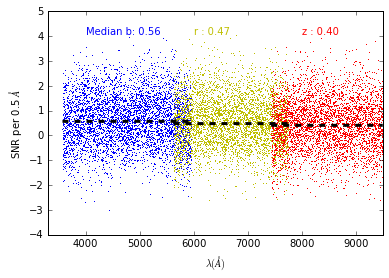

In [11]:
plot_snr(0)

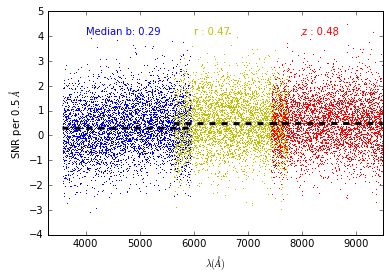

In [12]:
plot_snr(2)

In [13]:
print hdus[0][4].columns.names

['OBJTYPE', 'TARGETCAT', 'BRICKNAME', 'TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'MAG', 'FILTER', 'SPECTROID', 'POSITIONER', 'FIBER', 'LAMBDAREF', 'RA_TARGET', 'DEC_TARGET', 'RA_OBS', 'DEC_OBS', 'X_TARGET', 'Y_TARGET', 'X_FVCOBS', 'Y_FVCOBS', 'Y_FVCERR', 'X_FVCERR', 'NIGHT', 'EXPID']


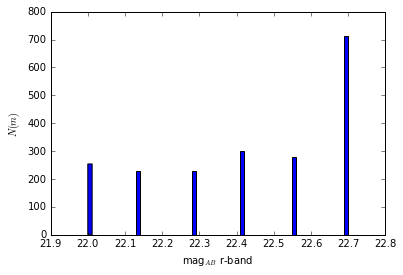

In [14]:
plt.hist(hdus[0][4].data['MAG'][:,2],bins=60)
plt.xlabel('mag$_{AB}$ r-band')
plt.ylabel('$N(m)$')